# Step 1: Minimal Octo Inference Example

This notebook demonstrates how to load a pre-trained / finetuned Octo checkpoint, run inference on some images, and compare the outputs to the true actions.

First, let's start with a minimal example!

In [ ]:
# run this block if you're using Colab

# Download repo
!git clone https://github.com/octo-models/octo.git
%cd octo
# Install repo
!pip3 install -e .
!pip3 install -r requirements.txt
!pip3 install --upgrade "jax[cuda11_pip]==0.4.20" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install numpy==1.21.1 # to fix colab AttributeError: module 'numpy' has no attribute '_no_nep50_warning', if the error still shows reload

In [1]:
import os
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

In [5]:
from octo.model.octo_model import OctoModel
model = OctoModel.load_pretrained("hf://rail-berkeley/octo-small-1.5")
config = model.config
print(list(config['dataset_kwargs'].keys()))

Fetching 6 files: 100%|██████████| 6/6 [00:00<00:00, 74455.10it/s]


['balance_weights', 'batch_size', 'dataset_kwargs_list', 'frame_transform_kwargs', 'sample_weights', 'shuffle_buffer_size', 'traj_read_threads', 'traj_transform_kwargs', 'traj_transform_threads']


: 

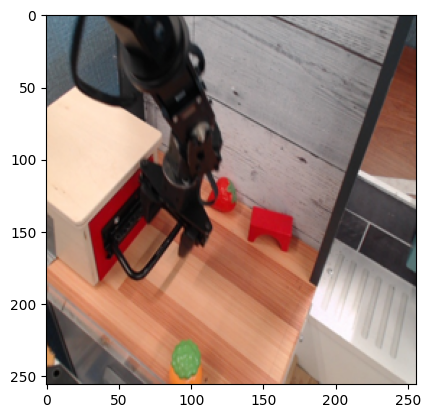

In [3]:
from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np
# download one example BridgeV2 image
IMAGE_URL = "https://rail.eecs.berkeley.edu/datasets/bridge_release/raw/bridge_data_v2/datacol2_toykitchen7/drawer_pnp/01/2023-04-19_09-18-15/raw/traj_group0/traj0/images0/im_12.jpg"
img = np.array(Image.open(requests.get(IMAGE_URL, stream=True).raw).resize((256, 256)))
plt.imshow(img)

In [ ]:
# create obs & task dict, run inference
import jax
# add batch + time horizon 1
img = img[np.newaxis,np.newaxis,...]
observation = {"image_primary": img, "timestep_pad_mask": np.array([[True]])}
task = model.create_tasks(texts=["pick up the fork"])
action = model.sample_actions(
    observation, 
    task, 
    unnormalization_statistics=model.dataset_statistics["bridge_dataset"]["action"], 
    rng=jax.random.PRNGKey(0)
)
print(action)   # [batch, action_chunk, action_dim]

[[[ 2.5662584e-03 -6.1310842e-05 -1.7947577e-02  5.9203096e-02
   -4.6430263e-03 -1.6368393e-02  9.9712259e-01]
  [-1.3877864e-03  1.8525787e-03 -1.0727847e-02  1.0303019e-02
    2.3530530e-02  2.0798495e-02  1.0012332e+00]
  [ 9.0697402e-04  1.2560134e-03 -3.2581536e-03  2.2115128e-03
    1.7177518e-02  2.3126965e-02 -1.0156323e-03]
  [-1.3609189e-03 -3.0430099e-03 -2.2453954e-03 -3.1563815e-02
    5.1578535e-03  2.5276391e-02 -7.4782909e-04]]]


: 

# Step 2: Run Inference on Full Trajectories

That was easy! Now let's try to run inference across a whole trajectory and visualize the results!

In [5]:
# Install mediapy for visualization
!pip install mediapy
!pip install opencv-python

In [1]:
import cv2
import jax
import tensorflow_datasets as tfds
import tqdm
import mediapy
import numpy as np

/home/server/anaconda3/envs/octo4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Model Checkpoint
First, we will load the pre-trained checkpoint using the `load_pretrained()` function. You can specify the path to a checkpoint directory or a HuggingFace path.

Below, we are loading directly from HuggingFace.


In [7]:
from octo.model.octo_model import OctoModel

model = OctoModel.load_pretrained("hf://rail-berkeley/octo-small-1.5")
config = model.config

Fetching 6 files: 100%|██████████| 6/6 [00:00<00:00, 127745.30it/s]


## Load Data
Next, we will load a trajectory from the Bridge dataset for testing the model. We will use the publicly available copy in the Open X-Embodiment dataset bucket.

In [8]:
# create RLDS dataset builder
builder = tfds.builder_from_directory(builder_dir='gs://gresearch/robotics/bridge/0.1.0/')
ds = builder.as_dataset(split='train[:1]')

# sample episode + resize to 256x256 (default third-person cam resolution)
episode = next(iter(ds))
steps = list(episode['steps'])
images = [cv2.resize(np.array(step['observation']['image']), (256, 256)) for step in steps]

# extract goal image & language instruction
goal_image = images[-1]
language_instruction = steps[0]['observation']['natural_language_instruction'].numpy().decode()

# visualize episode
print(f'Instruction: {language_instruction}')
mediapy.show_video(images, fps=10)

2025-02-13 20:04:46.681933: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


Instruction: Place the can to the left of the pot.


## Run Inference

Next, we will run inference over the images in the episode using the loaded model. 
Below we demonstrate setups for both goal-conditioned and language-conditioned training.
Note that we need to feed inputs of the correct temporal window size.

In [9]:
WINDOW_SIZE = 2

# create `task` dict
task = model.create_tasks(goals={"image_primary": goal_image[None]})   # for goal-conditioned
task = model.create_tasks(texts=[language_instruction])                  # for language conditioned

In [10]:
# run inference loop, this model only uses 3rd person image observations for bridge
# collect predicted and true actions
pred_actions, true_actions = [], []
for step in tqdm.trange(len(images) - (WINDOW_SIZE - 1)):
    input_images = np.stack(images[step:step+WINDOW_SIZE])[None]
    observation = {
        'image_primary': input_images,
        'timestep_pad_mask': np.full((1, input_images.shape[1]), True, dtype=bool)
    }
    
    # this returns *normalized* actions --> we need to unnormalize using the dataset statistics
    actions = model.sample_actions(
        observation, 
        task, 
        unnormalization_statistics=model.dataset_statistics["bridge_dataset"]["action"], 
        rng=jax.random.PRNGKey(0)
    )
    actions = actions[0] # remove batch dim

    pred_actions.append(actions)
    final_window_step = step + WINDOW_SIZE - 1
    true_actions.append(np.concatenate(
        (
            steps[final_window_step]['action']['world_vector'], 
            steps[final_window_step]['action']['rotation_delta'], 
            np.array(steps[final_window_step]['action']['open_gripper']).astype(np.float32)[None]
        ), axis=-1
    ))

100%|██████████| 37/37 [00:07<00:00,  5.22it/s]


## Visualize predictions and ground-truth actions

Finally, we will visualize the predicted actions in comparison to the groundtruth actions.

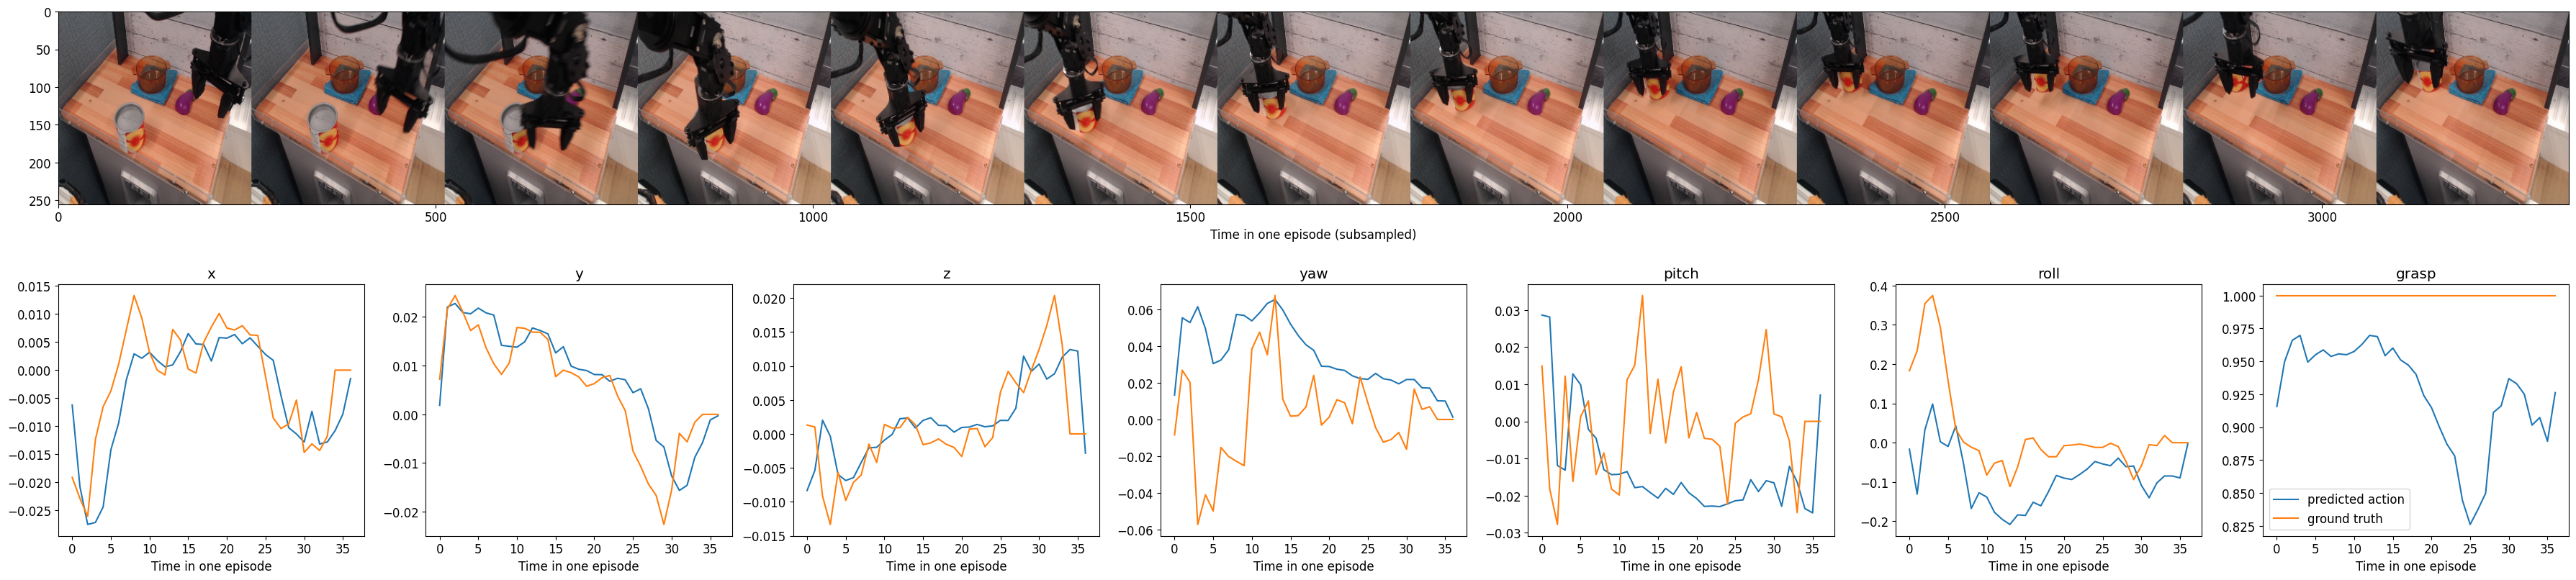

In [11]:
import matplotlib.pyplot as plt

ACTION_DIM_LABELS = ['x', 'y', 'z', 'yaw', 'pitch', 'roll', 'grasp']

# build image strip to show above actions
img_strip = np.concatenate(np.array(images[::3]), axis=1)

# set up plt figure
figure_layout = [
    ['image'] * len(ACTION_DIM_LABELS),
    ACTION_DIM_LABELS
]
plt.rcParams.update({'font.size': 12})
fig, axs = plt.subplot_mosaic(figure_layout)
fig.set_size_inches([45, 10])

# plot actions
pred_actions = np.array(pred_actions).squeeze()
true_actions = np.array(true_actions).squeeze()
for action_dim, action_label in enumerate(ACTION_DIM_LABELS):
  # actions have batch, horizon, dim, in this example we just take the first action for simplicity
  axs[action_label].plot(pred_actions[:, 0, action_dim], label='predicted action')
  axs[action_label].plot(true_actions[:, action_dim], label='ground truth')
  axs[action_label].set_title(action_label)
  axs[action_label].set_xlabel('Time in one episode')

axs['image'].imshow(img_strip)
axs['image'].set_xlabel('Time in one episode (subsampled)')
plt.legend()